Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [54]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [55]:
# I am setting a blank data_dir_prefix ... 
# this can be modified when using google colab to run the notebook by uncommenting the below code.
data_dir_prefix = ""

In [56]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

## data_dir_prefix = "/content/gdrive/My Drive/upgrad_cnn/"

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [62]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(data_dir_prefix + "Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(data_dir_prefix + "Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [63]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [64]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [66]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [67]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [68]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [69]:
# selecting a batch which has all the 9 classes
# I am saving the image, label arrays from that batch in images_to_keep and labels_to_keep
# I will use the image, label arrays to plot an example of each of the nine classes in the next cell
n = 0
images_to_keep, labels_to_keep = None, None
for images, labels in train_ds:
    if sorted(list(set(np.array(labels)))) == list(range(9)):
        print(n, labels)
        images_to_keep = images
        labels_to_keep = labels
        break
    n += 1

3 tf.Tensor([3 5 5 3 5 2 5 5 5 4 3 4 3 1 3 3 0 3 1 1 5 5 3 7 8 4 5 5 8 6 5 4], shape=(32,), dtype=int32)


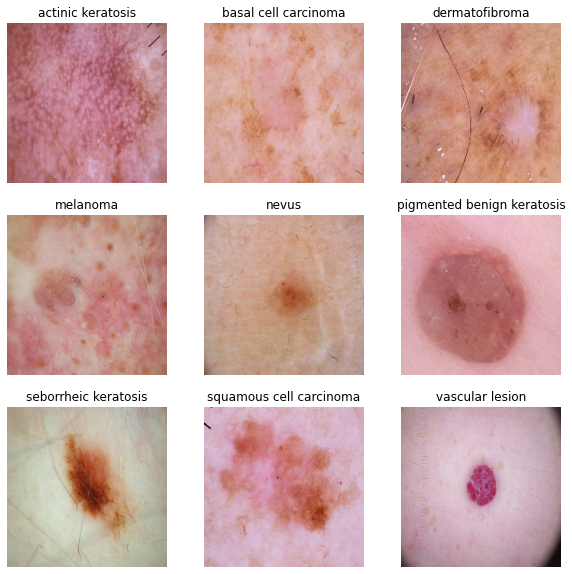

In [70]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))

for i in range(num_classes):
    ax = plt.subplot(3, 3, i + 1)
    idx = list(np.where(labels_to_keep == i)[0])[0]
    #print(list(np.where(labels==i)[0]))
    plt.imshow(images_to_keep[idx].numpy().astype("uint8"))
    plt.title(class_names[labels[idx]])
    plt.axis("off")
        

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [71]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [72]:
train_ds.element_spec[0].shape

TensorShape([None, 180, 180, 3])

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [73]:
# I am using the CIFAR 16 model but with less no. of filters & without dropout as my initial model
model = Sequential()
# Added the rescaling layer here
model.add(layers.Rescaling(1./255, input_shape = (train_ds.element_spec[0].shape[1:]))) 
model.add(layers.Conv2D(16, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(16, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [74]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [75]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_24 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 178, 178, 16)      2320      
                                                                 
 activation_25 (Activation)  (None, 178, 178, 16)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                      

### Train the model

In [76]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 129ms/step - loss: 2.0229 - accuracy: 0.2327 - val_loss: 1.8626 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.7893 - accuracy: 0.3382 - val_loss: 1.6264 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.6994 - accuracy: 0.3806 - val_loss: 1.5649 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.5033 - accuracy: 0.4788 - val_loss: 1.6033 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.3542 - accuracy: 0.5162 - val_loss: 1.4385 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 1.2937 - accuracy: 0.5508 - val_loss: 1.4504 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 2s 37ms/step - loss: 1.1935 - accuracy: 0.5859 - val_loss: 1.4500 - val_accuracy: 0.4989
Epoch 8/20


### Visualizing training results

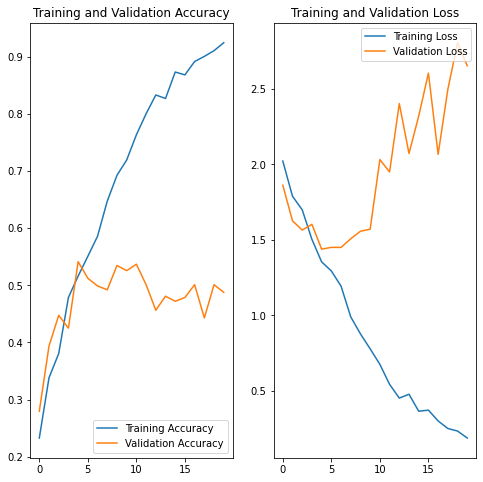

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here

#### Ans. From the above observation of the training accuracy (0.92) being much higher than the validation accuracy (0.48), it is clear that the above model is **overfitting** the data. As seen in the above digrams as well, the training loss kept decreasing but the validation loss stopped decreasing after second epoch itself. 


In [78]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# I am creating a data augmentation layer below, which I will add to the model subsequently
data_augmentation_layer = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",
                                                        interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)





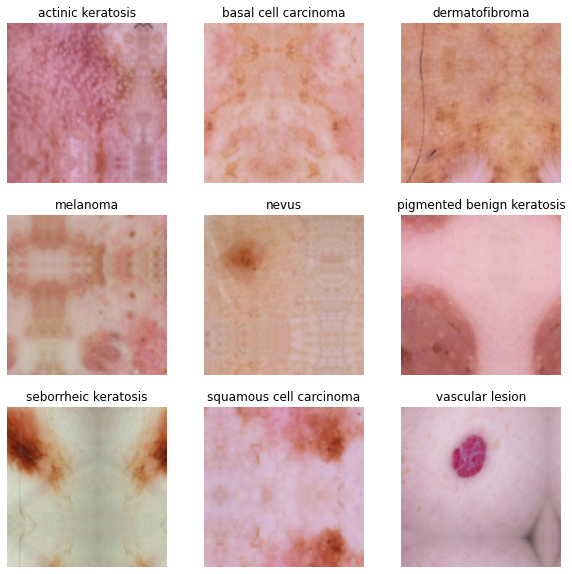

In [79]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# I am applying the data_augmentation_layer to the images_to_keep data batch extracted above for visualization
augmented_images = data_augmentation_layer(images_to_keep)

plt.figure(figsize = (10, 10))
for i in range(num_classes):
    ax = plt.subplot(3, 3, i + 1)
    idx = list(np.where(labels_to_keep == i)[0])[0]
    #print(list(np.where(labels==i)[0]))
    aug_image = augmented_images[idx]
    plt.imshow(aug_image.numpy().astype("uint8"))
    plt.title(class_names[labels[idx]])
    plt.axis("off")
        

### Todo:
### Create the model, compile and train the model


In [80]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
## I am building a new model called "model_w_aug" adding an augmentation layer before normalizing the input
## I am also adding dropout after each MaxPooling Layer
model_w_aug = Sequential()
# Added the rescaling layer here
model_w_aug.add(data_augmentation_layer)
model_w_aug.add(layers.Rescaling(1./255)) #, input_shape = (train_ds.element_spec[0].shape[1:]))) 
model_w_aug.add(layers.Conv2D(16, (3, 3), padding='same'))
model_w_aug.add(layers.Activation('relu'))
model_w_aug.add(layers.Conv2D(16, (3, 3)))
model_w_aug.add(layers.Activation('relu'))
model_w_aug.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_w_aug.add(layers.Dropout(0.25))

model_w_aug.add(layers.Conv2D(32, (3, 3), padding='same'))
model_w_aug.add(layers.Activation('relu'))
model_w_aug.add(layers.Conv2D(32, (3, 3)))
model_w_aug.add(layers.Activation('relu'))
model_w_aug.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_w_aug.add(layers.Dropout(0.25))

model_w_aug.add(layers.Flatten())
model_w_aug.add(layers.Dense(256))
model_w_aug.add(layers.Activation('relu'))
model_w_aug.add(layers.Dropout(0.5))
model_w_aug.add(layers.Dense(num_classes))
model_w_aug.add(layers.Activation('softmax'))



### Compiling the model

In [81]:
## Your code goes here
model_w_aug.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_w_aug.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_30 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 16)      2320      
                                                                 
 activation_31 (Activation)  (None, 178, 178, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 89, 89, 16)      

### Training the model

In [82]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_w_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 39s 461ms/step - loss: 2.7844 - accuracy: 0.1936 - val_loss: 2.0504 - val_accuracy: 0.1879
Epoch 2/20
56/56 [==============================] - 25s 449ms/step - loss: 2.0653 - accuracy: 0.1775 - val_loss: 2.0296 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 24s 430ms/step - loss: 2.0408 - accuracy: 0.1897 - val_loss: 2.0124 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 26s 454ms/step - loss: 2.0312 - accuracy: 0.2070 - val_loss: 2.0511 - val_accuracy: 0.2774
Epoch 5/20
56/56 [==============================] - 26s 459ms/step - loss: 2.0093 - accuracy: 0.1959 - val_loss: 1.9654 - val_accuracy: 0.2461
Epoch 6/20
56/56 [==============================] - 25s 454ms/step - loss: 1.9798 - accuracy: 0.2121 - val_loss: 1.9124 - val_accuracy: 0.2595
Epoch 7/20
56/56 [==============================] - 27s 473ms/step - loss: 1.9704 - accuracy: 0.2690 - val_loss: 1.9342 - val_accuracy: 0.3020
Epoch 8/20

### Visualizing the results

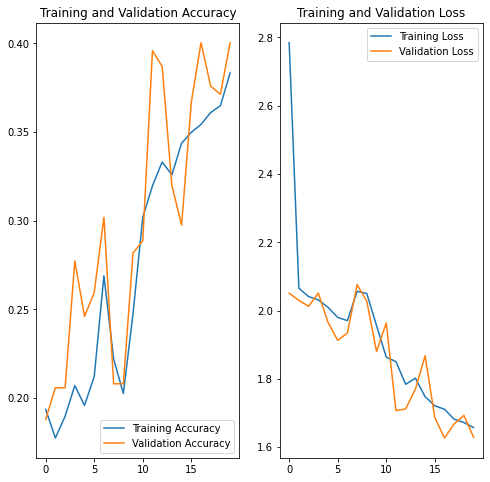

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Ans. The model fit seems much better as compared to the previous edition, although the accuracy for both train and validation sets is pretty low (~0.40). There doesnt seem to be any under or overfitting. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [85]:
## Your code goes here.
from glob import glob
# using glob to create a list of paths to all images across all train subdirectories 
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [86]:
# We can use the path_list, lesion list lists to create a dataframe of all training images 
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,actinic keratosis
1,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,actinic keratosis
2,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,actinic keratosis
3,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,actinic keratosis
4,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,basal cell carcinoma
2235,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,basal cell carcinoma
2236,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,basal cell carcinoma
2237,/content/gdrive/My Drive/upgrad_cnn/Skin cance...,basal cell carcinoma


Class=0, n=114 (5.092%)
Class=3, n=438 (19.562%)
Class=2, n=95 (4.243%)
Class=4, n=357 (15.945%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=5, n=462 (20.634%)
Class=1, n=376 (16.793%)


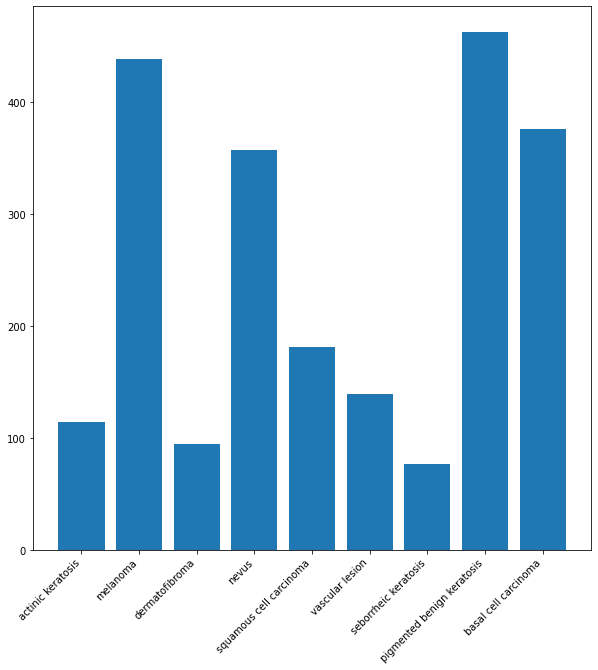

In [87]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# split into input and output elements
X, y = original_df['Path'], original_df['Label']

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
plt.figure(figsize = (10, 10))
plt.bar([class_names[k] for k in counter.keys()], counter.values())
plt.xticks(rotation=45, ha='right')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### Ans. **seborrheic keratosis**

#### - Which classes dominate the data in terms proportionate number of samples?
#### Ans. The four classes - **melanoma, nevus, pigmented bening keratosis**, and **basal cell carcinoma** dominate the dataset 


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [88]:
!pip3 install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [89]:
path_to_training_dataset = data_dir_prefix + "Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA9AB3C2130>: 100%|██████████| 500/500 [00:27<00:00, 17.99 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA9AB4B1070>: 100%|██████████| 500/500 [00:25<00:00, 19.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA301418E0>: 100%|██████████| 500/500 [00:22<00:00, 22.34 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=964x640 at 0x7FA9AB5AE520>: 100%|██████████| 500/500 [01:33<00:00,  5.36 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA9AC149490>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA302FD070>: 100%|██████████| 500/500 [00:22<00:00, 22.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA9A8477100>: 100%|██████████| 500/500 [00:49<00:00, 10.07 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA99AA72100>: 100%|██████████| 500/500 [00:21<00:00, 23.02 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA950E8B610>: 100%|██████████| 500/500 [00:22<00:00, 22.03 Samples/s]


In [90]:
###data_dir_prefix = "/content/gdrive/My Drive/upgrad_cnn/"

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [91]:
# Let's print the new image count after addressing class imbalance
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [92]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029025.jpg_daa13e6a-5b83-4094-a37c-c455b4acd3be.jpg',
 '/content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_cbabe386-a619-4c96-95ab-6eb386c1e543.jpg',
 '/content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_28a2d2c7-3865-4b0f-a92e-3ff9c75fe66f.jpg',
 '/content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_7489fc21-1bd2-4b14-a04e-c1e6d3cc0ce8.jpg',
 '/content/gdrive/My Drive/upgrad_cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/outp

In [93]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [94]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [95]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [96]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [97]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [98]:
data_dir_train = data_dir_prefix + "Skin cancer ISIC The International Skin Imaging Collaboration/Train" #"path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [99]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [100]:
## your code goes here
model_w_class_bal = Sequential()
# Added the rescaling layer here
# Since we added augmentation while supplementing the dataset, I am not adding the augmentation layer here 
model_w_class_bal.add(layers.Rescaling(1./255, input_shape = (train_ds.element_spec[0].shape[1:]))) 
model_w_class_bal.add(layers.Conv2D(16, (3, 3), padding='same'))
model_w_class_bal.add(layers.Activation('relu'))
model_w_class_bal.add(layers.Conv2D(16, (3, 3)))
model_w_class_bal.add(layers.Activation('relu'))
model_w_class_bal.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_w_class_bal.add(layers.Dropout(0.25))

model_w_class_bal.add(layers.Conv2D(32, (3, 3), padding='same'))
model_w_class_bal.add(layers.Activation('relu'))
model_w_class_bal.add(layers.Conv2D(32, (3, 3)))
model_w_class_bal.add(layers.Activation('relu'))
model_w_class_bal.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_w_class_bal.add(layers.Dropout(0.25))

model_w_class_bal.add(layers.Flatten())
model_w_class_bal.add(layers.Dense(256))
model_w_class_bal.add(layers.Activation('relu'))
model_w_class_bal.add(layers.Dropout(0.5))
model_w_class_bal.add(layers.Dense(num_classes))
model_w_class_bal.add(layers.Activation('softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [101]:
## your code goes here
model_w_class_bal.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_w_class_bal.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_36 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 16)      2320      
                                                                 
 activation_37 (Activation)  (None, 178, 178, 16)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 16)       0         
 g2D)                                                            
                                                      

#### **Todo:**  Train your model

In [102]:
epochs = 20
## Your code goes here
history = model_w_class_bal.fit(train_ds,
  validation_data = val_ds,
  epochs = epochs) # your model fit code

Epoch 1/20
169/169 [==============================] - 43s 233ms/step - loss: 2.0915 - accuracy: 0.2094 - val_loss: 1.9546 - val_accuracy: 0.2784
Epoch 2/20
169/169 [==============================] - 39s 226ms/step - loss: 1.7146 - accuracy: 0.3470 - val_loss: 1.5884 - val_accuracy: 0.3823
Epoch 3/20
169/169 [==============================] - 37s 216ms/step - loss: 1.5108 - accuracy: 0.4240 - val_loss: 1.3550 - val_accuracy: 0.4699
Epoch 4/20
169/169 [==============================] - 35s 199ms/step - loss: 1.2983 - accuracy: 0.5082 - val_loss: 1.1858 - val_accuracy: 0.5553
Epoch 5/20
169/169 [==============================] - 34s 198ms/step - loss: 1.1417 - accuracy: 0.5727 - val_loss: 1.0889 - val_accuracy: 0.6080
Epoch 6/20
169/169 [==============================] - 37s 209ms/step - loss: 0.9520 - accuracy: 0.6452 - val_loss: 0.9514 - val_accuracy: 0.6637
Epoch 7/20
169/169 [==============================] - 39s 224ms/step - loss: 0.8265 - accuracy: 0.6986 - val_loss: 0.8529 - val_ac

#### **Todo:**  Visualize the model results

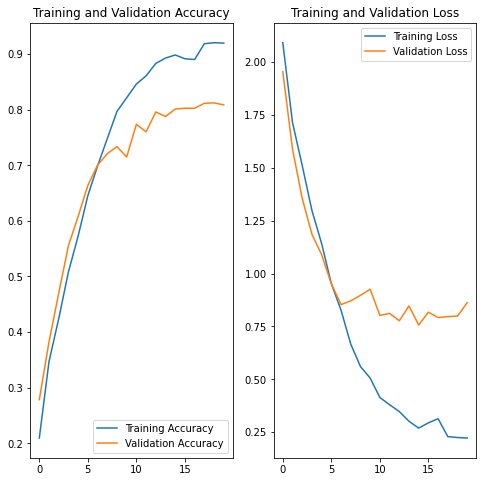

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Ans. Within the same number of epochs, i.e. 20, the model fit improved drastically after class balancing for both the train and validation sets. Although, there is still quite a difference b/w the accuracies for the two datasets. The training accuracy (0.9197) is still much higher than the validation accuracy (0.8085), indicating some overfitting still remains. 

